In [1]:
import matplotlib.pyplot as plt
import  numpy as np
import pandas as pd
import random
import seaborn as sns
import os, gc, warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lightgbm

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
import catboost as cat
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss

In [4]:
%matplotlib inline
pd.set_option('display.max_columns', 150)
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.size'] = 12
pd.set_option('display.max_colwidth', 2000)

In [5]:
data_train = pd.read_csv("C:\\Users\\mariam  ayomi\\Desktop\\loan dataset\\Train.csv")
data_test = pd.read_csv("C:\\Users\\mariam  ayomi\\Desktop\\loan dataset\\Test.csv")
submission = pd.read_csv("C:\\Users\\mariam  ayomi\\Desktop\\loan dataset\\SampleSubmission.csv")  

In [6]:
data_train.skew()

form_field1       0.120458
form_field2       4.299532
form_field3       4.233351
form_field4       5.427310
form_field5      10.465192
form_field6       6.203867
form_field7      36.556045
form_field8       3.935070
form_field9       3.503331
form_field10     18.007423
form_field11      9.633062
form_field12      4.734462
form_field13     53.667658
form_field14    118.547478
form_field15      5.533132
form_field16      3.999875
form_field17      5.044450
form_field18      4.966005
form_field19      3.327070
form_field20      3.174999
form_field21      1.714100
form_field22      0.799056
form_field23      0.901040
form_field24     30.440138
form_field25      1.711413
form_field26      1.471489
form_field27      1.452973
form_field28      0.993735
form_field29      0.933382
form_field30      0.038387
form_field31      0.738210
form_field32      2.447196
form_field33      1.565371
form_field34      6.205108
form_field35      4.167426
form_field36      2.634626
form_field37      1.949271
f

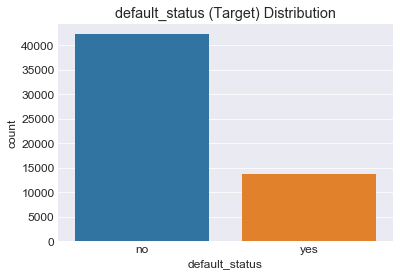

In [7]:
sns.countplot(data_train.default_status)
plt.title('default_status (Target) Distribution');

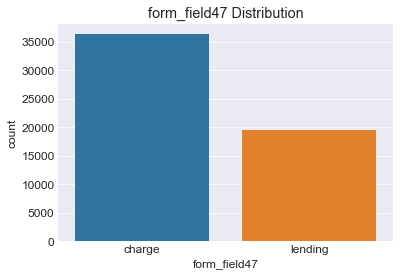

In [8]:
sns.countplot(data_train.form_field47)
plt.title('form_field47 Distribution');

In [9]:
data_train.isna().sum()/data_train.shape[0]

Applicant_ID      0.000000
form_field1       0.045161
form_field2       0.068643
form_field3       0.006339
form_field4       0.006339
form_field5       0.006339
form_field6       0.238571
form_field7       0.092196
form_field8       0.238571
form_field9       0.143000
form_field10      0.006339
form_field11      0.561089
form_field12      0.176696
form_field13      0.105161
form_field14      0.000000
form_field15      0.401339
form_field16      0.232786
form_field17      0.199125
form_field18      0.185750
form_field19      0.000071
form_field20      0.006339
form_field21      0.283107
form_field22      0.364286
form_field23      0.502196
form_field24      0.237446
form_field25      0.097321
form_field26      0.132821
form_field27      0.166054
form_field28      0.006339
form_field29      0.006339
form_field30      0.455518
form_field31      0.703714
form_field32      0.097321
form_field33      0.022429
form_field34      0.006339
form_field35      0.413357
form_field36      0.035625
f

The data_train has lot of missing values, and filling in these values with the mean, median or mode will not be good enough for the data, hence I resorted to not filling them with an arbitrarily high value (-999).

In [10]:
data_train['Applicant_ID'].value_counts()

Apcnt_1133020    1
Apcnt_1215176    1
Apcnt_1077584    1
Apcnt_1130848    1
Apcnt_1189568    1
                ..
Apcnt_1212712    1
Apcnt_1162304    1
Apcnt_1213496    1
Apcnt_928492     1
Apcnt_1041320    1
Name: Applicant_ID, Length: 56000, dtype: int64

In [11]:
data_train['default_status'].value_counts()/len(data_train)*100

no     75.508929
yes    24.491071
Name: default_status, dtype: float64

In [12]:
data_train['form_field47'].value_counts()

charge     36373
lending    19627
Name: form_field47, dtype: int64

In [13]:
dict_df = {'charge':0,
           'lending':1
}

data_train['form_field47'].replace(dict_df, inplace = True)

In [14]:
data_test['form_field47'].replace(dict_df, inplace = True)

In [15]:
dict_dff = {'no':0,
           'yes':1
}

data_train['default_status'].replace(dict_dff, inplace = True)

In [16]:
data_train.corr()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
form_field1,1.000000,-0.263382,-0.501989,-0.276037,-0.238508,0.413203,0.259690,0.590875,0.525935,0.407465,-0.153583,0.114070,0.215294,-0.000388,0.221777,-0.358931,-0.337144,-0.328799,-0.132694,-0.120122,-0.660555,-0.571553,-0.563135,-0.196751,0.363689,0.413191,0.412663,0.672904,0.382165,0.133906,0.161541,0.434963,0.279455,-0.240419,-0.449569,-0.250616,0.355200,-0.175042,-0.247064,-0.353256,-0.204252,-0.769666,0.436825,0.020987,-0.308952,-0.332168,0.275408,0.132836,-0.238500,0.119797,-0.414826
form_field2,-0.263382,1.000000,0.120889,0.089388,0.039718,-0.170318,-0.093021,-0.201365,-0.162909,-0.119794,0.032744,-0.020191,-0.061673,-0.002626,-0.083385,0.149014,0.156135,0.155464,0.173725,0.169172,0.230240,0.196388,0.194322,0.042393,-0.227523,-0.195153,-0.201512,-0.152192,-0.150598,-0.111648,-0.047096,-0.159920,-0.126830,0.066472,0.085852,0.155863,-0.141179,0.286332,0.055077,0.091068,0.152294,0.133388,0.017639,-0.097404,0.059398,0.103379,-0.077816,-0.062440,0.145432,-0.045105,0.226313
form_field3,-0.501989,0.120889,1.000000,0.376795,0.649863,-0.122285,-0.082032,-0.204138,-0.208045,-0.142977,0.274955,-0.146730,-0.096685,0.002931,-0.109164,0.112651,0.099204,0.093814,-0.059005,-0.064309,0.227824,0.204264,0.200595,0.260630,-0.084565,-0.083395,-0.082616,-0.313532,-0.068792,-0.000498,-0.011322,-0.110955,-0.106021,0.091750,0.278551,0.367379,-0.055647,0.118169,0.129470,0.206044,0.026840,0.431644,-0.242528,-0.019430,0.268679,0.403775,-0.118335,-0.057103,0.195454,-0.041295,0.193603
form_field4,-0.276037,0.089388,0.376795,1.000000,0.099439,-0.068868,-0.044020,-0.113001,-0.122086,-0.072819,0.054434,-0.077544,-0.058123,0.001613,-0.066745,0.067484,0.055088,0.053039,-0.032456,-0.036008,0.141518,0.115507,0.108360,0.061925,-0.073411,-0.081038,-0.081060,-0.172557,-0.058339,-0.028399,-0.006445,-0.106202,-0.074035,0.100506,0.124129,0.145442,-0.085796,0.071416,0.127197,0.108336,0.000609,0.217256,-0.133150,0.002108,0.134662,0.885903,-0.073147,-0.030856,-0.021376,-0.023217,0.147548
form_field5,-0.238508,0.039718,0.649863,0.099439,1.000000,-0.044174,-0.047210,-0.072429,-0.089868,-0.070542,0.208195,-0.062838,-0.040539,-0.002897,-0.060073,0.040042,0.031849,0.028336,-0.049761,-0.053361,0.097076,0.096654,0.098971,0.038798,-0.058490,-0.069961,-0.067958,-0.119099,-0.051931,-0.026266,0.006949,-0.089523,-0.066943,0.017233,0.085714,0.231836,-0.073118,0.030339,0.064247,0.154767,0.033270,0.232948,-0.130958,-0.069985,0.041071,0.125941,-0.052391,-0.022956,0.470998,-0.016133,0.088912
form_field6,0.413203,-0.170318,-0.122285,-0.068868,-0.044174,1.000000,0.188560,0.491946,0.256348,0.230088,0.014199,-0.060717,0.166417,0.007264,0.163450,-0.162042,-0.160101,-0.159048,-0.256100,-0.252150,-0.413309,-0.319040,-0.316810,-0.067937,0.319588,0.240703,0.255656,0.297190,0.218260,0.079006,0.085487,0.132497,0.157392,-0.109839,-0.098758,-0.201247,0.098013,-0.207570,-0.075067,-0.154338,-0.110028,-0.202840,-0.055535,0.154622,-0.076431,-0.065658,0.134062,0.051453,-0.235662,0.075432,-0.165438
form_field7,0.259690,-0.093021,-0.082032,-0.044020,-0.047210,0.188560,1.000000,0.340538,0.271203,0.899833,-0.003793,0.117215,0.291038,0.007267,0.252285,-0.061424,-0.059498,-0.056095,-0.060212,-0.048688,-0.173720,-0.132694,-0.124450,-0.029375,0.223234,0.232219,0.233136,0.134676,0.224416,0.124168,0.124560,0.238958,0.181887,-0.014851,-0.058196,-0.047147,0.192821

In [17]:
data_train.drop(['form_field48', 'form_field49'], axis = 1, inplace = True)
data_test.drop(['form_field48', 'form_field49'], axis = 1, inplace = True)

I dropped form_field48 nd form_field49 because they are undefine

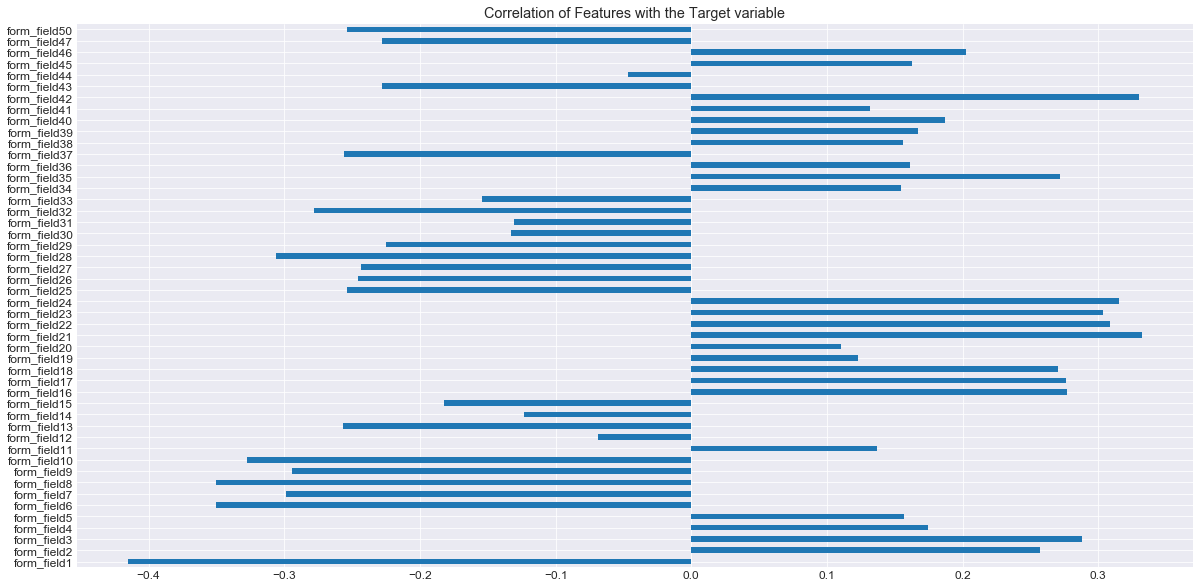

In [18]:
data_train.corr('spearman')['default_status'][:-1].plot.barh(figsize=(20,10), 
                                          title='Correlation of Features with the Target variable');

I checked the correlation of each feautures with the target variables. 
Most of them are in postitvely(weakly) correlated with the Target.

In [19]:
df = data_train.append(data_test)[data_train.columns]

In [20]:
data_train = df[df.default_status.notna()]
data_test = df[df.default_status.isna()].drop('default_status', 1)

In [21]:
data_train.shape, data_test.shape

((56000, 50), (24000, 49))

# modelling

In [22]:
#reproducibility
seed = 10
random.seed(seed)
np.random.seed(seed)

In [23]:
def crossVal(model):
    avg = 0
    for fold, (tr, te) in enumerate(skfolds.split(xtrainval, ytrainval), 1):
        train_x, test_x = xtrainval.iloc[tr], xtrainval.iloc[te]
        train_y, test_y = ytrainval.iloc[tr], ytrainval.iloc[te]
        
        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], 
                  early_stopping_rounds=200, verbose=False)
        preds = model.predict_proba(test_x)[:,1]
        logloss = log_loss(test_y, preds)
        print(f'Fold {fold}: Logloss: {logloss}')
        avg += logloss
    free = gc.collect()
    print(f'Avg Logloss: {avg/fold}')

In [24]:
def crossValPred(model):
    avg = 0
    test_scores = []
    for fold, (tr, te) in enumerate(skfolds.split(X, y), 1):
        train_x, test_x = X.iloc[tr], X.iloc[te]
        train_y, test_y = y.iloc[tr], y.iloc[te]
        
        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], 
                  early_stopping_rounds=200, verbose=False)
        
        preds = model.predict_proba(test_x)[:, 1]
        logloss = log_loss(test_y, preds)
        print(f'Fold {fold}: Logloss: {logloss}')
        avg += logloss
        
        
        test_pred = model.predict_proba(test)[:,1]
        test_scores.append(test_pred)
    print(f'Avg Logloss: {avg/fold}')
    free = gc.collect()
    return np.mean(test_scores, 0)

In [25]:
def plot_graph(model, xtr, ytr, ax=None):
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    plot_confusion_matrix(model, xtr, ytr, ax=ax[0])
    ax[0].grid(False)
    plot_roc_curve(model, xtr, ytr, ax=ax[1])

In [26]:
cat_cols = data_train.select_dtypes('object').columns.drop(['Applicant_ID'], 1)

In [27]:
data_train.fillna(-999, inplace=True)
data_test.fillna(-999, inplace=True)

In [28]:
skfolds= StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [29]:
X = data_train.drop(['default_status', 'Applicant_ID'], axis = 1)
y = data_train['default_status']
test = data_test.drop(['Applicant_ID'], 1)

In [30]:
xtrainval, xtest, ytrainval, ytest = train_test_split(X, y, test_size=0.15, stratify=y, random_state=seed)
xtrain, xval, ytrain, yval = train_test_split(xtrainval, ytrainval, test_size=0.25, stratify=ytrainval, random_state=seed)

In [31]:
xtrain.shape, xval.shape, xtest.shape

((35700, 48), (11900, 48), (8400, 48))

Catboost

In [32]:
catm = cat.CatBoostClassifier(random_seed=seed, cat_features=cat_cols, bootstrap_type='Bernoulli', 
                              iterations=1000, silent=True, eval_metric='Logloss')

In [33]:
%%time
catm.fit(xtrain, ytrain, eval_set=[(xval,yval)], early_stopping_rounds=350, verbose=200);

Learning rate set to 0.076633
0:	learn: 0.6454840	test: 0.6449046	best: 0.6449046 (0)	total: 297ms	remaining: 4m 56s
200:	learn: 0.3835167	test: 0.3986955	best: 0.3986955 (200)	total: 7.31s	remaining: 29.1s
400:	learn: 0.3543832	test: 0.3972958	best: 0.3972207 (398)	total: 15.1s	remaining: 22.6s
600:	learn: 0.3303957	test: 0.3974390	best: 0.3971399 (427)	total: 22.3s	remaining: 14.8s
Stopped by overfitting detector  (350 iterations wait)

bestTest = 0.3971398635
bestIteration = 427

Shrink model to first 428 iterations.
Wall time: 32.4 s


In [34]:
crossVal(catm)

Fold 1: Logloss: 0.399621135322001
Fold 2: Logloss: 0.41310485874465663
Fold 3: Logloss: 0.41286598778934275
Fold 4: Logloss: 0.3990150486815898
Fold 5: Logloss: 0.40989103630248547
Avg Logloss: 0.40689961336801517


In [35]:
gc.collect()

0

In [36]:
cat_pred = crossValPred(catm)

Fold 1: Logloss: 0.4077061863745905
Fold 2: Logloss: 0.4075904560839473
Fold 3: Logloss: 0.41007412598652765
Fold 4: Logloss: 0.4015789001363771
Fold 5: Logloss: 0.40308706497732855
Avg Logloss: 0.4060073467117542


Lgboost

In [37]:
X[cat_cols] = X[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

In [38]:
xtrainval, xtest, ytrainval, ytest = train_test_split(X, y, test_size=0.15, stratify=y, random_state=seed)
xtrain, xval, ytrain, yval = train_test_split(xtrainval, ytrainval, test_size=0.20, stratify=ytrainval, random_state=seed)

In [39]:
lgbm = lgb.LGBMClassifier(random_state=seed, n_estimators=1000, metric='binary_logloss', learning_rate=0.04, subsample=0.7,
                         colsample_bytree=0.8, num_leaves=64, reg_alpha=4, min_child_samples=5,subsample_freq=2)

In [40]:
lgbm.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xval,yval)], verbose=200, early_stopping_rounds=200);

Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.33641	valid_1's binary_logloss: 0.399624
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.33668	valid_1's binary_logloss: 0.399593


In [41]:
crossVal(lgbm)

Fold 1: Logloss: 0.40033104171643547
Fold 2: Logloss: 0.41638500396779593
Fold 3: Logloss: 0.4141603044749991
Fold 4: Logloss: 0.4012744745406205
Fold 5: Logloss: 0.41021439795563575
Avg Logloss: 0.40847304453109734


In [42]:
gc.collect()

0

In [43]:
lgb_pred = crossValPred(lgbm)

Fold 1: Logloss: 0.40866274647319406
Fold 2: Logloss: 0.4074623394070153
Fold 3: Logloss: 0.4113560416397751
Fold 4: Logloss: 0.4012167806834956
Fold 5: Logloss: 0.40397207740183744
Avg Logloss: 0.40653399712106353


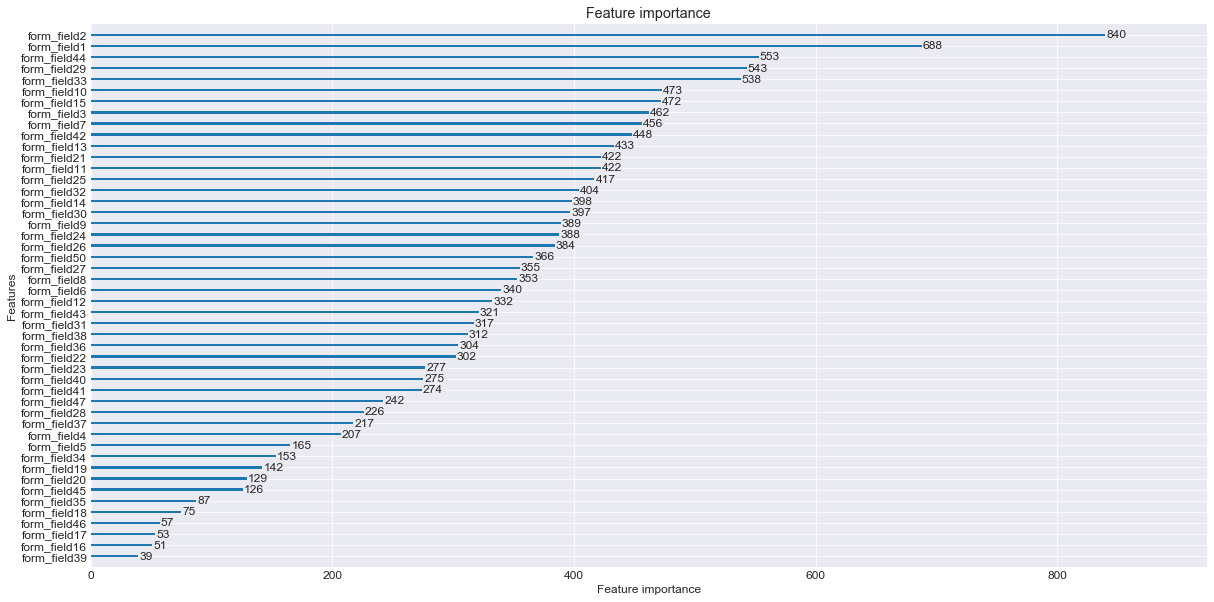

In [44]:
lgb.plot_importance(lgbm, figsize=(20,10), importance_type='split');

My submission

In [45]:
blend = ((0.4 * lgb_pred + 0.6 * cat_pred) + (0.6 * lgb_pred + 0.4 * cat_pred))/2

In [46]:
Applicant_id = data_test.Applicant_ID

In [47]:
lgb_df =  pd.DataFrame({'Applicant_ID' : Applicant_id, 'default_status' : lgb_pred})
cat_df =  pd.DataFrame({'Applicant_ID' : Applicant_id, 'default_status' : cat_pred})
blend_df =  pd.DataFrame({'Applicant_ID' : Applicant_id, 'default_status' : blend})

In [48]:
pd.DataFrame(np.c_[lgb_pred, cat_pred, blend], columns=['Lgb', 'Cat', 'Blend'])

,Lgb,Cat,Blend
0,0.234854,0.305413,0.270134
1,0.390667,0.369761,0.380214
2,0.399113,0.393125,0.396119
3,0.753134,0.743733,0.748433
4,0.142290,0.202679,0.172484
...,...,...,...
23995,0.716352,0.711389,0.713870
23996,0.259495,0.245003,0.252249
23997,0.236414,0.271417,0.253915
23998,0.531271,0.529178,0.530224


In [50]:
lgb_df.to_csv("C:\\Users\\mariam  ayomi\\Desktop\\loan dataset\\submission.Lgb.csv")
cat_df.to_csv("C:\\Users\\mariam  ayomi\\Desktop\\loan dataset\\submission.Cat.csv")
blend_df.to_csv("C:\\Users\\mariam  ayomi\\Desktop\\loan dataset\\submission.Blend.csv")

In [51]:
gc.collect()

12115